In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128
# Plot size to 14" x 7"
mpl.rc('figure', figsize = (14, 7))
# Font size to 14
mpl.rc('font', size = 14)
# Do not display top and right frame lines
mpl.rc('axes.spines', top = False, right = False)
# Remove grid lines
mpl.rc('axes', grid = False)
# Set backgound color to white
mpl.rc('axes', facecolor = 'white')

In [2]:
# read whole year data
allFiles = glob.glob("data/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
df = pd.concat(list_)

df.columns = map(str.lower, df.columns)

In [3]:
selected_features = ['marketing code','suburb', 'state','post code','enquired',
                     'loan amount','loan_reason','property_use']
target = 'enquiry status';
whole_set = selected_features + [target]

df = df[whole_set]
df = df.replace('On Hold','Rejected')
# convert loan amount to number type, and change string to NaN
df['loan amount'] = pd.to_numeric(df['loan amount'],errors='coerce')

In [4]:
print("Shape of data frame: {}".format(df.shape))
print("Keys of enquiries_dataset: \n{}".format(df.keys()))
print("data ytpes of enquiries_dataset: \n{}".format(df.dtypes))

Shape of data frame: (48026, 9)
Keys of enquiries_dataset: 
Index(['marketing code', 'suburb', 'state', 'post code', 'enquired',
       'loan amount', 'loan_reason', 'property_use', 'enquiry status'],
      dtype='object')
data ytpes of enquiries_dataset: 
marketing code     object
suburb             object
state              object
post code         float64
enquired           object
loan amount       float64
loan_reason        object
property_use       object
enquiry status     object
dtype: object


In [5]:
for _ in df.columns:
    print("The number of null values in:{} == {}".format(_, df[_].isnull().sum()))

The number of null values in:marketing code == 22
The number of null values in:suburb == 12422
The number of null values in:state == 12369
The number of null values in:post code == 4283
The number of null values in:enquired == 0
The number of null values in:loan amount == 600
The number of null values in:loan_reason == 9354
The number of null values in:property_use == 9375
The number of null values in:enquiry status == 0


In [6]:
# set all null loan amount to mean valu
df['loan amount'] = df['loan amount'].fillna(df['loan amount'].mean())
for _ in df.columns:
    print("The number of null values in:{} == {}".format(_, df[_].isnull().sum()))

The number of null values in:marketing code == 22
The number of null values in:suburb == 12422
The number of null values in:state == 12369
The number of null values in:post code == 4283
The number of null values in:enquired == 0
The number of null values in:loan amount == 0
The number of null values in:loan_reason == 9354
The number of null values in:property_use == 9375
The number of null values in:enquiry status == 0


In [7]:
df = df.dropna(axis=0, how='any')
df = df[~df[target].isin(['In Progress','Just Received'])]

In [8]:
def changeDateType(df): 

    df['enquired'] = pd.DatetimeIndex(df['enquired'])
    df['loan amount'] = df['loan amount'].astype(int)
    df['post code'] = df['post code'].astype(int)
    return df

df = changeDateType(df)
print("data ytpes of enquiries_dataset: \n{}".format(df.dtypes))

data ytpes of enquiries_dataset: 
marketing code            object
suburb                    object
state                     object
post code                  int64
enquired          datetime64[ns]
loan amount                int64
loan_reason               object
property_use              object
enquiry status            object
dtype: object


In [9]:
from datetime import datetime
from dateutil.parser import parse

# filter years
start_date = '2017-01-01' 
end_date = '2017-12-31'
mask = (df['enquired'] > start_date) & (df['enquired'] <= end_date)
df = df.loc[mask].reset_index(drop=True)


    
def getDetailDate(df):
    # remove Year feature since it is not important (show below random forest)
    # data_set['Year'] = data_set['Enquired'].dt.year
    df['month'] = df['enquired'].dt.month
    df['day'] = df['enquired'].dt.day
    df['hour'] = df['enquired'].dt.hour
    df['weekday'] = df['enquired'].dt.weekday_name

    df = df.loc[:,df.columns != 'enquired']
    return df
    
df = getDetailDate(df)

In [10]:
df

,marketing code,suburb,state,post code,loan amount,loan_reason,property_use,enquiry status,month,day,hour,weekday
0,DOM35,Westmead,NSW,2145,570000,First HomeBuyer,Residence,Rejected,7,28,12,Friday
1,A9471,Wallan,VIC,3756,280000,First HomeBuyer,Residence,Rejected,11,24,16,Friday
2,A9234,Sawtell,NSW,2452,300000,Buying Again,Investment,Rejected,11,25,7,Saturday
3,A9452,Singleton,NSW,2330,310000,Refinance,Residence,Rejected,11,25,7,Saturday
4,GA07,Alfredton,VIC,3350,270000,First HomeBuyer,Residence,Rejected,11,25,15,Saturday
5,AH04,West Wyalong,NSW,2671,109000,Buying Again,Residence,Rejected,11,26,10,Sunday
6,A9819,Asquith,NSW,2077,360000,First HomeBuyer,Investment,Rejected,11,26,17,Sunday
7,A9234,St Johns Park,NSW,2176,570000,Buying Again,Investment,Rejected,11,26,18,Sunday
8,GA01,Yorkeys Knob,QLD,4878,190000,First HomeBuyer,Investment,Rejected,11,27,15,Monday
9,A9432,Panania,NSW,2213,290000,Refinance With Cash Out,Residence,Accepted,11,30,18,Thursday


In [11]:
# from sklearn.preprocessing import LabelEncoder

# class MultiColumnLabelEncoder:
#     def __init__(self,columns = None):
#         self.columns = columns # array of column names to encode

#     def fit(self,X,y=None):
#         return self # not relevant here

#     def transform(self,X):
#         '''
#         Transforms columns of X specified in self.columns using
#         LabelEncoder(). If no columns specified, transforms all
#         columns in X.
#         '''
#         output = X.copy()
#         if self.columns is not None:
#             for col in self.columns:
#                 output[col] = LabelEncoder().fit_transform(output[col].astype(str))
#         else:
#             for colname,col in output.iteritems():
#                 output[colname] = LabelEncoder().fit_transform(col)
#         return output

#     def fit_transform(self,X,y=None):
#         return self.fit(X,y).transform(X)

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
label_df = df.apply(le.fit_transform)

In [13]:
X = label_df[df.keys()]
X = label_df.loc[:,df.columns != target]
y = label_df[target]

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class PreProcessing(BaseEstimator, TransformerMixin):
    """Custom Pre-Processing estimator for our use-case
    """

    def __init__(self):
        pass

    def transform(self, df):
 
        return df.as_matrix()

    def fit(self, df, y=None, **fit_params):
        return self

In [15]:
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                     test_size=0.4,
                     random_state=0,
                     stratify=y)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import learning_curve

pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(penalty='l2',C=0.01,random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Test Accuracy: 0.855


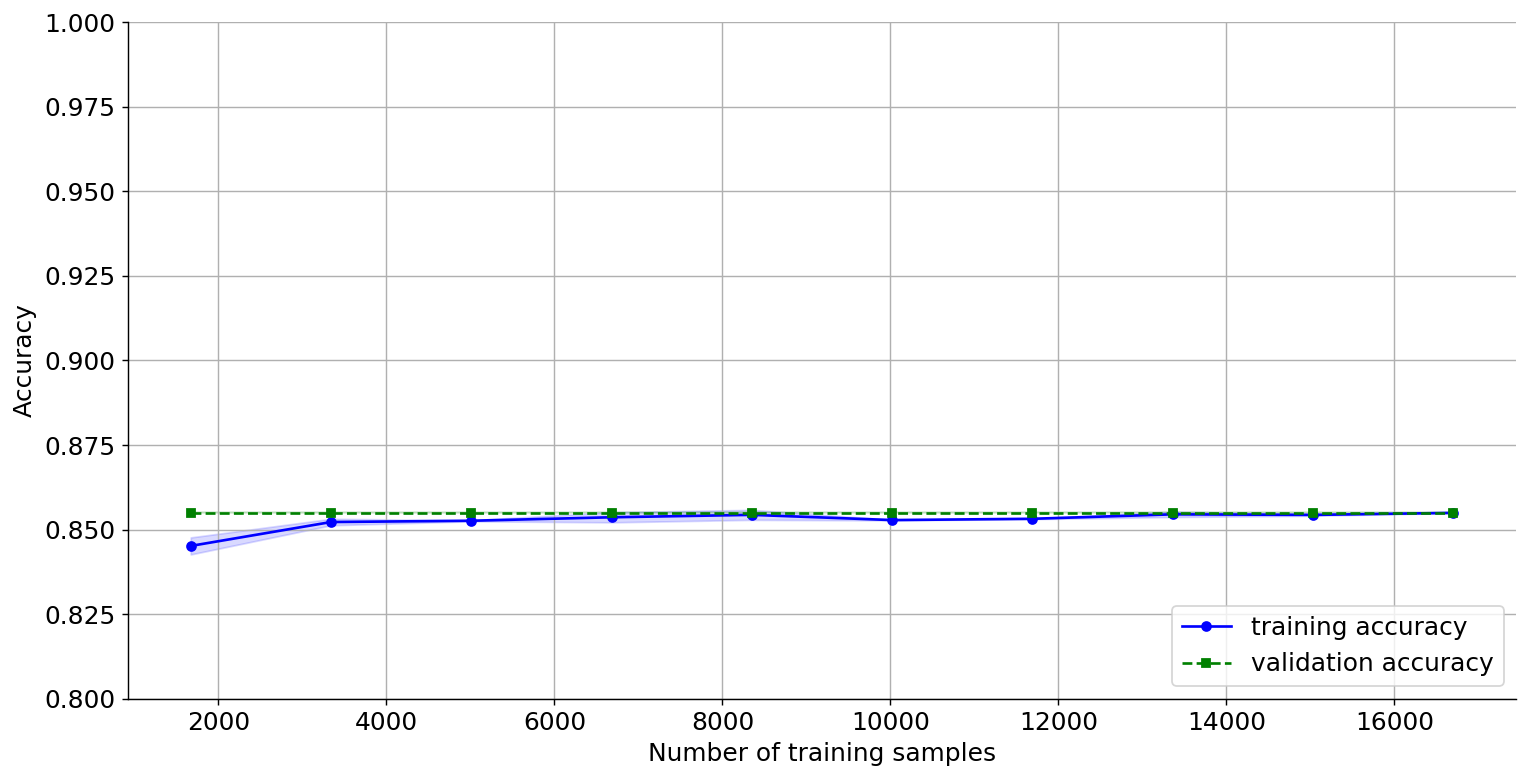

In [17]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

In [18]:
results=[]
for pl, tl, idx, chg in zip(y_pred, y_test, y_test.index, X.iloc[y_test.index]):
    if pl == tl:
        results.append([idx, chg, pl, tl, 1])
    else:
        results.append([idx, chg, pl, tl, 0])

In [19]:
from sklearn import cross_validation
from sklearn.metrics import classification_report

scores = cross_validation.cross_val_score(pipe_lr, X, y, cv=5)
print("LogisticRegression cross_validation: {:.2f}".format(np.mean(scores, axis=0)))


print("LogisticRegression")
print(classification_report(y_test, y_pred))

LogisticRegression cross_validation: 0.85
LogisticRegression
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1795
          1       0.85      1.00      0.92     10577

avg / total       0.73      0.85      0.79     12372



In [20]:
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

# rescale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rfc = RandomForestClassifier(n_estimators=500,random_state=1)
rfc.fit(X_train_scaled, y_train)
pred_forest = rfc.predict(X_test)

print("Test score: {:.2f}".format(rfc.score(X_test_scaled, y_test)))


Test score: 0.90


 1) marketing code                 0.151534
 2) suburb                         0.136927
 3) loan amount                    0.134410
 4) post code                      0.125177
 5) loan_reason                    0.105643
 6) day                            0.087694
 7) hour                           0.084154
 8) month                          0.059095
 9) weekday                        0.053624
10) property_use                   0.034870
11) state                          0.026872


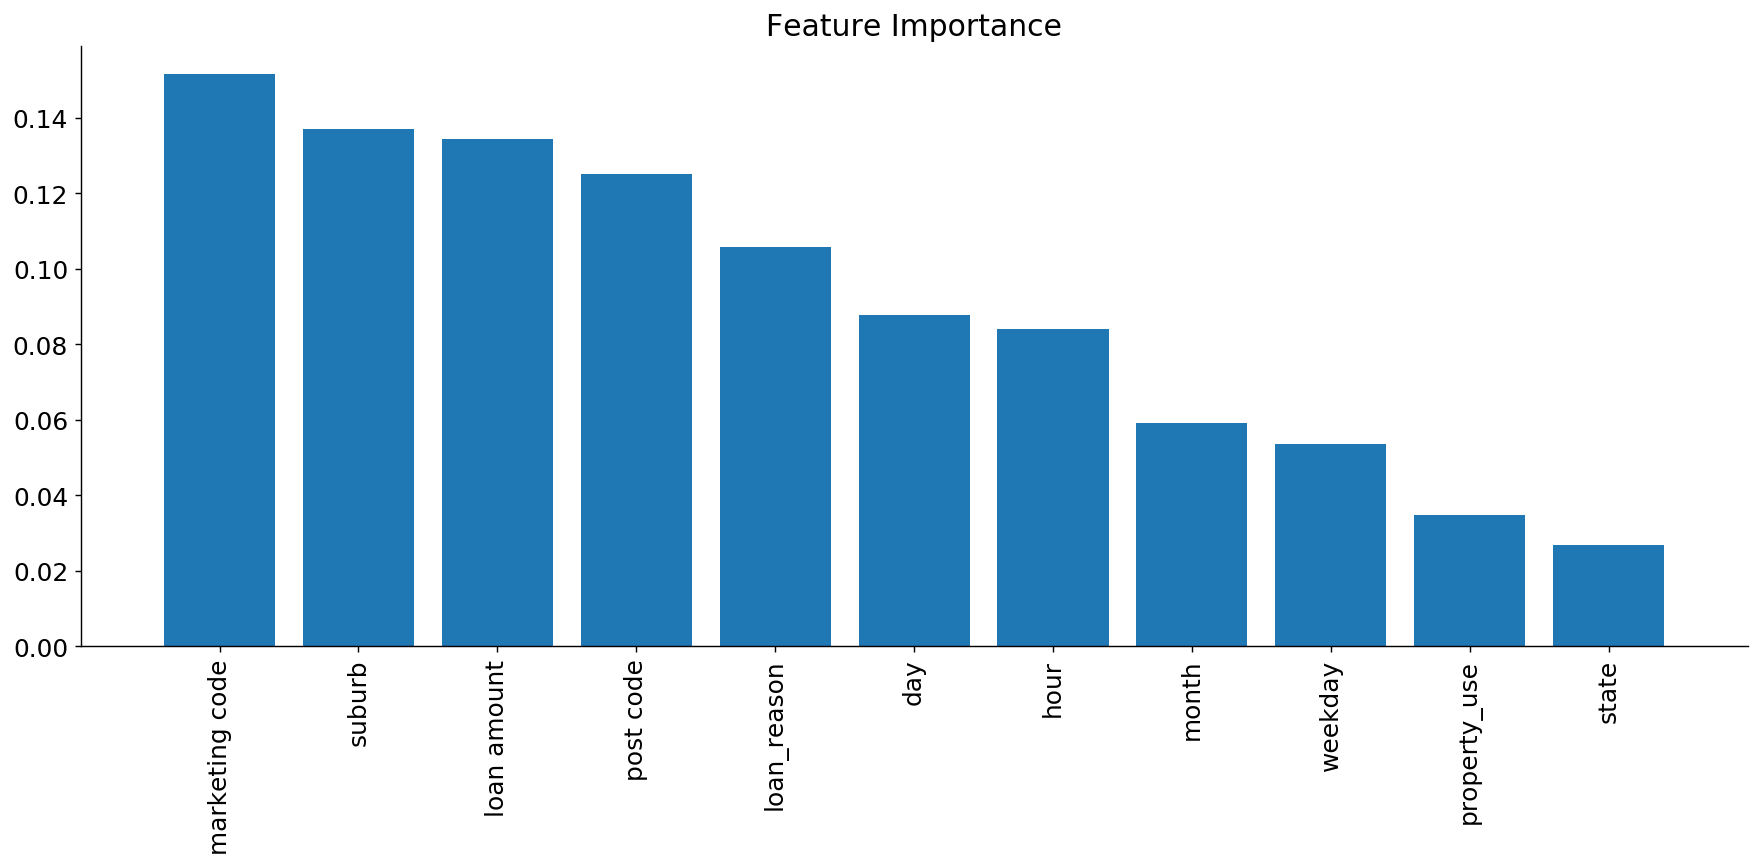

In [21]:
feat_labels = X.columns[0:]
importances = rfc.feature_importances_

# reverse the list
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]],importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[indices],align='center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [22]:
# import pickle
# import os

# dest = os.path.join('movieclassifier', 'pkl_objects')
# if not os.path.exists(dest):
#     os.makedirs(dest)

# pickle.dump(stop,open(os.path.join(dest, 'stopwords.pkl'),'wb'),protocol=4)
# pickle.dump(clf,
            
from sklearn.externals import joblib
joblib.dump(pipe_lr, 'app/models/lrpipeline.pkl')

['app/models/lrpipeline.pkl']

In [23]:
model_columns = list(X.columns)
joblib.dump(model_columns, 'app/models/model_columns.pkl')

['app/models/model_columns.pkl']

In [24]:
clf = joblib.load('app/models/lrpipeline.pkl')
model_columns = joblib.load('app/models/model_columns.pkl')

In [25]:
data = "[\n  {\n    \"Marketing Code\": \"A9301\",\n    \"Classification\": \"Folio\",\n    \"Enquired\": \"27/10/14 18:53\",\n    \"Loan Amount\": 485000,\n    \"Suburb\": \"BYRON BAY\",\n    \"State\": \"NSW\",\n    \"Post Code\": 2481,\n    \"loan_reason\": \"First HomeBuyer\",\n    \"property_use\": \"Residence\"\n  },\n  {\n    \"Marketing Code\": \"P00019\",\n    \"Classification\": \"Domain Campaigns\",\n    \"Enquired\": \"15/5/15 10:26\",\n    \"Loan Amount\": 500000,\n    \"Suburb\": \"Sydney\",\n    \"State\": \"NSW\",\n    \"Post Code\": 2000,\n    \"loan_reason\": \"Refinance\",\n    \"property_use\": \"Residence\"\n  },\n  {\n    \"Marketing Code\": \"P00019\",\n    \"Classification\": \"Domain Campaigns\",\n    \"Enquired\": \"19/6/15 8:25\",\n    \"Loan Amount\": 500000,\n    \"Suburb\": \"Homebush West\",\n    \"State\": \"NSW\",\n    \"Post Code\": 2140,\n    \"loan_reason\": \"First HomeBuyer\",\n    \"property_use\": \"Residence\"\n  }\n]"

In [26]:
# test = pd.read_json(data, orient='records')
model_columns
# query = pd.get_dummies(test)

['marketing code',
 'suburb',
 'state',
 'post code',
 'loan amount',
 'loan_reason',
 'property_use',
 'month',
 'day',
 'hour',
 'weekday']

In [27]:
import json
my_json_string = json.dumps({
    "marketing_code": "Z1234",
    "post code": "2223",
    "suburb": "Oatley",
    "state": "NSW",
    "enquired":"08-1-2018 12:06:24",
    "property_use": "residence",
    "loan_reason": "refinance",
    "state": "NSW",
    "loan amount": "500000"
})
my_json_string

'{"marketing_code": "Z1234", "post code": "2223", "suburb": "Oatley", "state": "NSW", "enquired": "08-1-2018 12:06:24", "property_use": "residence", "loan_reason": "refinance", "loan amount": "500000"}'

In [28]:
# test = pd.read_json(my_json_string, orient='index')
# data = pd.read_json(my_json_string, typ='series',orient='index')
# data = pd.DataFrame(data=data)
data = json.loads(my_json_string)
data = pd.DataFrame(data,index=[0])

In [29]:
data = changeDateType(data)
data = getDetailDate(data)
data = data.apply(le.fit_transform)

In [30]:
clf = joblib.load('app/models/lrpipeline.pkl')

In [31]:
prediction = clf.predict(data)

In [32]:
prediction

array([1])